Last Modifed:July 23, 2019

Description: This notebook builds a simple neural network and trains it. The data used is from a Kaggle dataset (Intel Image Classification).

This one uses torch and fastai.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import torch
import fastai
import time

print('pytorch version: ',torch.__version__)
print('fastai version: ',fastai.__version__)

pytorch version:  1.1.0
fastai version:  1.0.54


The data is loaded from folders as a DataBunch.

In [2]:
path=Path('./')
data=ImageDataBunch.from_folder(path,train='seg_train',valid='seg_test',
                                  ds_tfms=get_transforms(do_flip=True,flip_vert=True,max_rotate=25),
                                  size=150,bs=64,num_workers=4).normalize(imagenet_stats)

print('Number of Classes: ',len(data.classes))

Number of Classes:  6


The pretrained model is declared.

In [3]:
model=cnn_learner(data,models.resnet50,metrics=accuracy,model_dir="/tmp/model/")

The model is then trained, the "base model" layers are frozen by default.

In [4]:
t=time.time()

history=model.fit_one_cycle(15)

elapsed=time.time()-t

epoch,train_loss,valid_loss,accuracy,time
0,0.532404,0.357347,0.867333,01:19
1,0.452841,0.318410,0.884333,01:15
2,0.397750,0.283108,0.896000,01:15
3,0.366470,0.273617,0.896667,01:15
4,0.346265,0.255230,0.905000,01:15
5,0.296083,0.263987,0.900667,01:15
6,0.286704,0.232292,0.917000,01:15
7,0.261066,0.237863,0.912333,01:15
8,0.247784,0.223378,0.924667,01:16
9,0.238668,0.208542,0.923000,01:15


The accuracy is calculated.

In [6]:
acc1=[]

for val in model.recorder.metrics:
    acc1.append(val[0].item())

The model is saved and the metrics, plots, and learning rate are plotted.

In [8]:
model.save('round_1')

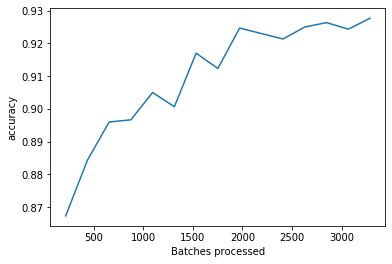

In [9]:
model.recorder.plot_metrics()

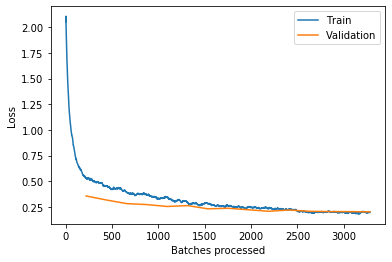

In [10]:
model.recorder.plot_losses()

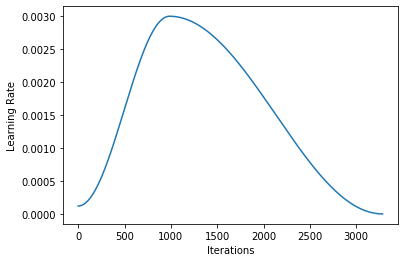

In [11]:
model.recorder.plot_lr()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


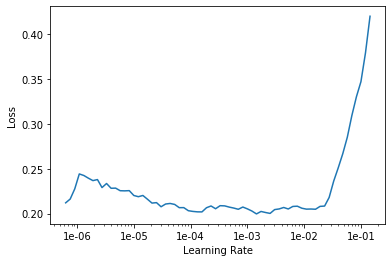

In [12]:
model.lr_find()

model.recorder.plot()

The layers are then unfrozen and the model trained again.

In [13]:
model.unfreeze()

t=time.time()

model.fit_one_cycle(20)

elapsed_fine=time.time()-t

epoch,train_loss,valid_loss,accuracy,time
0,0.199372,0.220938,0.921000,01:43
1,0.234656,0.262728,0.907667,01:42
2,0.303021,0.261276,0.904667,01:42
3,0.332320,0.279958,0.896000,01:42
4,0.325925,0.401460,0.856333,01:42
5,0.322049,0.320752,0.883000,01:42
6,0.309573,0.304574,0.894333,01:43
7,0.294242,0.256837,0.903667,01:43
8,0.265721,0.266014,0.901333,01:43
9,0.226717,0.264003,0.913000,01:42


In [14]:
elapsed_fine

2058.8104643821716

In [15]:
elapsed_total=elapsed+elapsed_fine

The accuracy from training is recorded and the plots of accuracy, loss, and learning rate are made.

In [16]:
acc2=[]

for val in model.recorder.metrics:
    acc2.append(val[0].item())

In [17]:
model.save('round_2')

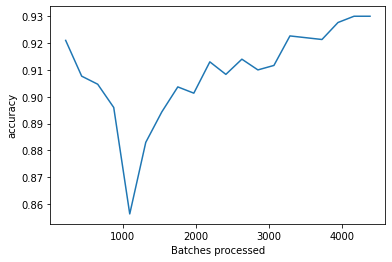

In [18]:
model.recorder.plot_metrics()

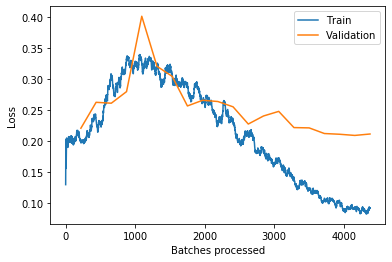

In [19]:
model.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


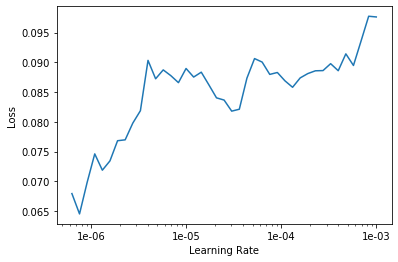

In [20]:
model.lr_find()

model.recorder.plot()

The total accuracy is plotted.

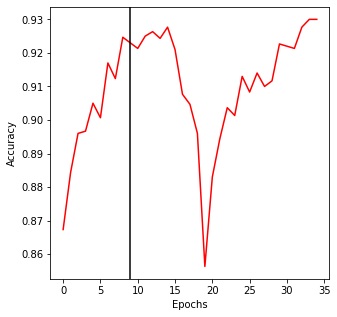

In [21]:
plt.figure(figsize=(5,5))
plt.plot(acc1+acc2,'r',label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axvline(x=9,color='black')

Predictions are made from the trained model.

In [22]:
preds=model.get_preds()

In [23]:
y=preds[1].numpy()

In [24]:
p=[]

np.argmax(preds[0].numpy()[0])
for val in preds[0].numpy():
    p.append(np.argmax(val))
    
p=np.array(p)

The confusion matrix and classification report are generated.

In [25]:
conf=confusion_matrix(y, p)

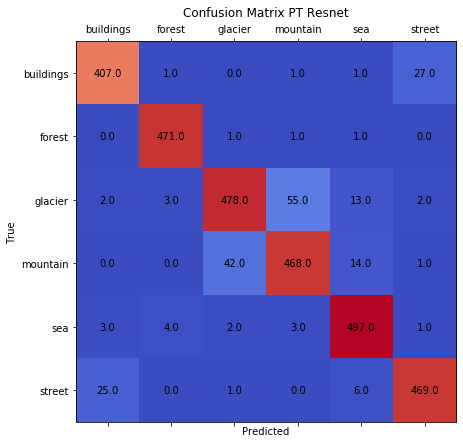

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(conf, cmap='coolwarm')
ax.set_xticklabels(['']+model.data.valid_ds.y.classes)
ax.set_yticklabels(['']+model.data.valid_ds.y.classes)
plt.title('Confusion Matrix PT Resnet')
plt.xlabel('Predicted')
plt.ylabel('True')

for (ii, jj), val in np.ndenumerate(conf):
    ax.text(jj, ii, '{:0.1f}'.format(val), ha='center', va='center')

plt.show()

In [27]:
CR=classification_report(y,p,target_names=model.data.valid_ds.y.classes)

print(CR)

              precision    recall  f1-score   support

   buildings       0.93      0.93      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.91      0.86      0.89       553
    mountain       0.89      0.89      0.89       525
         sea       0.93      0.97      0.95       510
      street       0.94      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



The final accuracy and total training time are reported and saved for comparison.

In [28]:
acc=accuracy_score(y,p)

print('Training Time: ', elapsed_total)
print('Final Accuracy: ', acc)

np.save('PT+fastai',(elapsed_total,acc))

Training Time:  3201.0501005649567
Final Accuracy:  0.93
